In [1]:
import pandas as pd
data=pd.read_csv("hotel-reviews.csv")
dum=pd.get_dummies(data[["Browser_Used","Device_Used"]])
data=pd.concat([data.drop(["Browser_Used","Device_Used"],axis=1),dum],axis=1)
print(data.columns)
data.head()

Index(['User_ID', 'Description', 'Is_Response', 'Browser_Used_Chrome',
       'Browser_Used_Edge', 'Browser_Used_Firefox',
       'Browser_Used_Google Chrome', 'Browser_Used_IE',
       'Browser_Used_Internet Explorer', 'Browser_Used_InternetExplorer',
       'Browser_Used_Mozilla', 'Browser_Used_Mozilla Firefox',
       'Browser_Used_Opera', 'Browser_Used_Safari', 'Device_Used_Desktop',
       'Device_Used_Mobile', 'Device_Used_Tablet'],
      dtype='object')


,User_ID,Description,Is_Response,Browser_Used_Chrome,Browser_Used_Edge,Browser_Used_Firefox,Browser_Used_Google Chrome,Browser_Used_IE,Browser_Used_Internet Explorer,Browser_Used_InternetExplorer,Browser_Used_Mozilla,Browser_Used_Mozilla Firefox,Browser_Used_Opera,Browser_Used_Safari,Device_Used_Desktop,Device_Used_Mobile,Device_Used_Tablet
0,id10326,The room was kind of clean but had a VERY stro...,not happy,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,id10328,I booked this hotel through Hotwire at the low...,not happy,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,id10329,Stayed here with husband and sons on the way t...,happy,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,id10330,My girlfriends and I stayed here to celebrate ...,not happy,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [2]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
stop_words = set(stopwords.words('english'))
lemma=WordNetLemmatizer()
def process(x):
    x=re.sub("[^a-zA-Z]+", " " ,x) #過濾掉非字母
    x=[lemma.lemmatize(w) for w in word_tokenize(str(x).lower())] #做詞形還原（lemmatization)
    x = [w for w in x if not w in stop_words] #remove stopwords
    x=' '.join(x)
    return x
data["Clean words"]=data["Description"].apply(process)
data["Length"]=data["Description"].apply(lambda x:len(x))

In [4]:
pd.value_counts(data["Is_Response"])

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

In [5]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
import numpy as np
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

C:\Users\POPO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy for training data: 0.9867118736943046
The accuracy for testing data: 0.8992088770163362


Most negative related feature: ['dirty' 'rude' 'worst' 'poor' 'terrible' 'old' 'nothing' 'uncomfortable'
 'ok' 'dark']
Most positive related feature: ['great' 'excellent' 'perfect' 'wonderful' 'loved' 'amazing'
 'definitely stay' 'comfortable' 'beautiful' 'spacious']
Normalized confusion matrix
[[0.92 0.08]
 [0.15 0.85]]


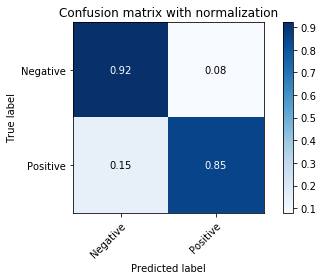

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data['Clean words'], 
                                                    data['Is_Response'], 
                                                    random_state=0)

vect = TfidfVectorizer(min_df=5, ngram_range=(1,3)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized=vect.transform(X_test)
clf = LogisticRegression(C=80)
X_train, X_test, y_train, y_test = train_test_split(data[['Length','Browser_Used_Chrome',
       'Browser_Used_Edge', 'Browser_Used_Firefox',
       'Browser_Used_Google Chrome', 'Browser_Used_IE',
       'Browser_Used_Internet Explorer', 'Browser_Used_InternetExplorer',
       'Browser_Used_Mozilla', 'Browser_Used_Mozilla Firefox',
       'Browser_Used_Opera', 'Browser_Used_Safari', 'Device_Used_Desktop',
       'Device_Used_Mobile', 'Device_Used_Tablet']], 
                                                    data['Is_Response'], 
                                                    random_state=0)

X_train_vectorized=add_feature(X_train_vectorized,X_train.T)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12,k_neighbors=5)
X_train_res, y_train_res = sm.fit_sample(X_train_vectorized, y_train)
clf.fit(X_train_res, y_train_res)
    
X_test_vectorized=add_feature(X_test_vectorized,X_test.T)

predictions = clf.predict(X_test_vectorized)
predictions_train = clf.predict(X_train_vectorized)

acc=(predictions==y_test).mean()
acctrain=(predictions_train==y_train).mean()

print("The accuracy for training data:",acctrain)
print("The accuracy for testing data:",acc)
print("\n")

class_names = ["Negative","Positive"]
feature_names = np.array(vect.get_feature_names()+["Length",'Browser_Used_Chrome',
       'Browser_Used_Edge', 'Browser_Used_Firefox',
       'Browser_Used_Google Chrome', 'Browser_Used_IE',
       'Browser_Used_Internet Explorer', 'Browser_Used_InternetExplorer',
       'Browser_Used_Mozilla', 'Browser_Used_Mozilla Firefox',
       'Browser_Used_Opera', 'Browser_Used_Safari', 'Device_Used_Desktop',
       'Device_Used_Mobile', 'Device_Used_Tablet'])

sorted_coef_index = clf.coef_[0].argsort()
positive=feature_names[sorted_coef_index[:10]]
negative=feature_names[sorted_coef_index[-10:]][::-1]
print("Most negative related feature:",negative)
print("Most positive related feature:",positive)
plot_confusion_matrix(list(y_test), list(predictions), classes=class_names,normalize=True,
                      title='Confusion matrix with normalization')

plt.show()